# M.0 Data initialization

In [1]:
import datetime

import time

import pyspark
import pyspark.sql.functions as f
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.types import *

import pandas as pd
import numpy as np


from tqdm import tqdm



import warnings
warnings.filterwarnings('ignore')

In [2]:
NUMBER_OF_THREADS_TO_USE = "*"
spark = SparkSession.builder \
    .master('local[' + NUMBER_OF_THREADS_TO_USE + ']') \
    .appName('discret_pierre_detection') \
    .config('spark.driver.memory', '200g') \
    .config('spark.driver.maxResultSize', '15g') \
    .config('spark.rapids.sql.enabled','true') \
    .getOrCreate()
sc = spark.sparkContext

spark

In [3]:
# some constants
LocationPrefix = "Paris"
DatasetPrefix = "Cancan"


# those are the metadata used to sum the number of requests
#meta = ['LocationId', 'MinuteWithinWeek']
meta = ['WeeksGroup', 'LocationId', 'MinuteWithinWeek']

# those are the metrics once we have gathered antennas and stuff
#metrics = ['Call','SMS','Data','Mobility','Signalling','Emergency','Overload']
metrics = ['Voice','SMS_3G','PS','CS','Call','SMS_4G','Service_Req','HO']


SourceParquetFilesLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris/'

ParquetFilesSignaturesLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_sigs_2/'
ParquetFilesDistribsLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_distribs_2/'

ParquetFilesALRsLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_ALR_2/'
CsvFilesThresholdsLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_Thresholds_2.csv'



## 0.1 Load and format data

In [4]:
#DistribsDFSP = spark.read.parquet('/WORKSPACE/Pierre/exports/Cancan_distribs_tmp/Paris/')


OriginalDataDFSP = spark.read.parquet(SourceParquetFilesLoc)
OriginalDataDFSP.printSchema()

SignaturesDFSP = spark.read.parquet(ParquetFilesSignaturesLoc)
SignaturesDFSP.printSchema()

DistribsDFSP = spark.read.parquet(ParquetFilesDistribsLoc)
DistribsDFSP.printSchema()

ThresholdsDF = pd.read_csv(CsvFilesThresholdsLoc)
print(ThresholdsDF.info(verbose=True))


root
 |-- time_utc: string (nullable = true)
 |-- time_local: timestamp (nullable = true)
 |-- Voice: long (nullable = true)
 |-- PS: long (nullable = true)
 |-- SMS_3G: long (nullable = true)
 |-- CS: long (nullable = true)
 |-- Service_Req: long (nullable = true)
 |-- Call: long (nullable = true)
 |-- SMS_4G: long (nullable = true)
 |-- HO: long (nullable = true)
 |-- MinuteWithinWeek: integer (nullable = true)
 |-- WeeksGroup: integer (nullable = true)
 |-- WeekOfYear: integer (nullable = true)
 |-- LocationId: integer (nullable = true)

root
 |-- MinuteWithinWeek: long (nullable = true)
 |-- Voice: double (nullable = true)
 |-- SMS_3G: double (nullable = true)
 |-- PS: double (nullable = true)
 |-- CS: double (nullable = true)
 |-- Call: double (nullable = true)
 |-- SMS_4G: double (nullable = true)
 |-- Service_Req: double (nullable = true)
 |-- HO: double (nullable = true)
 |-- WeeksGroup: integer (nullable = true)
 |-- LocationId: integer (nullable = true)

root
 |-- GammaParam:

In [6]:
LocIdsList = sorted([x.LocationId for x in DistribsDFSP.select('LocationId').distinct().collect()])

print("found " + str(len(LocIdsList)) + " location groups")

#print(LocIdsList)

AllWeeksIdsList = sorted([x.WeekOfYear for x in OriginalDataDFSP.select('WeekOfYear').distinct().collect()])

print("All Weeks Ids:")
print(AllWeeksIdsList)


AllWeeksGroupsList = sorted([x.WeeksGroup for x in OriginalDataDFSP.select('WeeksGroup').distinct().collect()])

print("All Groups Ids:")
print(AllWeeksGroupsList)



found 1026 location groups
All Weeks Ids:
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
All Groups Ids:
[0, 1, 2]


In [10]:
#from anr_discret import onlineMLbyPL

import scipy.stats as stats


MinALSThreshold = 1 / (60*24*365.25*10)

def compute_alr_eric_local(df:pd.DataFrame, distrib:dict, metrics:list) -> pd.DataFrame:
    """Computes the Anomaly Likelihood Rate (ALR) over the input dataframe.
    The ALR corresponds to the sum of the logs of the p-value for each service data.
    The p-value is obtained for each service data by fitting a Gamma distribution over the dataset.

    Parameters
    ----------
    df: pandas.core.frame.DataFrame
        The input dataframe (usually containing AE values)
    distrib: dict
        The error distribution parameters for all services
    metrics: list
        The list of column names corresponding to the service data

    Returns
    -------
    df: pandas.core.frame.DataFrame
        The same dataframe with the additional ALR column
    """

    res = pd.DataFrame().reindex_like(df)
    als = pd.DataFrame(index = res.index, columns = metrics)
    
    CopyCols = list(set(df.columns) - set(metrics))
    res[CopyCols] = df[CopyCols].copy(deep=True)

    for m in metrics:
        mLoc = df.columns.get_loc(m)
            
        SeparationThresh = distrib.loc['thresh',m]
        proba = distrib.loc['proba',m]
        nvalues = distrib.loc['nvalues',m]
        arg = distrib.loc['k',m]
        loc = distrib.loc['loc',m]
        scale = distrib.loc['theta',m]

        if nvalues<3:
            #print("case where the gamma law was not fitted on metric " + m)
            res.loc[:,m] = pd.Series(np.nan, index=df.index)
        else:
            # default value is 1-proba
            res.loc[:,m] = pd.Series((1. - proba), index=df.index)
            # the gamma law was fitted on this metric
            indexThresh = df.index[df[m]>SeparationThresh]

            res.loc[indexThresh,m] = (1. - proba) * stats.gamma.sf(df.loc[indexThresh, m], arg, loc=loc, scale=scale)
            res.loc[indexThresh,m].clip(lower=MinALSThreshold, inplace=True)

        als[m] = pd.Series(np.log(res[m]), index=res.index)

    res['ALR'] = als.sum(axis=1)
    return res




  
def set_levels_local(df, thresh):
    """Set anomaly levels on the input data according to the ALR value at each timestamp.
    The data can be labelled as: normal, pre-alert (level 1), alert (level 2), maximal anomaly (level 3).

    Parameters
    ----------
    df: pandas.core.frame.DataFrame
        The input dataframe with ALR values
    thresh: pandas.core.frame.Series
        The ALR thresholds of the dataframe for each anomaly level

    Returns
    -------
    df: pandas.core.frame.DataFrame
        The dataframe with anomaly levels (0 to 3)
    """

    df['Anomaly_Level'] = 0
    df.loc[df.ALR < thresh['level1byPL'], 'Anomaly_Level'] = 1
    df.loc[df.ALR < thresh['level2byPL'], 'Anomaly_Level'] = 2
    df.loc[df.ALR < thresh['level3byPL'], 'Anomaly_Level'] = 3
    return df




totalALR = []


with tqdm(total=len(LocIdsList)*len(AllWeeksGroupsList), desc='ALR computing') as pbar:
    # run 2 imbricated loops, this hasn't much consequence on the output thanks to the filter / partitioning thing 
    for WGrp in AllWeeksGroupsList:
    #for WGrp in range(0,1):
        
        GroupDFSP = OriginalDataDFSP.filter(OriginalDataDFSP.WeeksGroup==WGrp)
        TrainWeeksIdsList = sorted([x.WeekOfYear for x in GroupDFSP.select('WeekOfYear').distinct().collect()])
        TestWeeksIdsList = list(set(AllWeeksIdsList) - set(TrainWeeksIdsList))
        
        for LocId in LocIdsList:
            
            if LocId>20:
                break

            ReferenceDF = SignaturesDFSP.filter(SignaturesDFSP.LocationId == LocId).toPandas()

            ErrorsDFsList = []
            for wk in TestWeeksIdsList:
                wkDF = OriginalDataDFSP.drop('time_local').drop('time_utc').filter((OriginalDataDFSP.WeekOfYear==wk) & (OriginalDataDFSP.LocationId == LocId)).toPandas().set_index('MinuteWithinWeek')
                wkDF = wkDF.reindex(range(0,24*7*60), fill_value=0).assign(WeekOfYear=wk, LocationId=LocId, WeeksGroup=WGrp).fillna(0).reset_index()

                for m in metrics:
                    #wkDF[m] = abs(wkDF[m] - ReferenceDF[m])
                    wkDF[m] = wkDF[m] - ReferenceDF[m]

                #print("length wkDF :" + str(len(wkDF.index)))
                ErrorsDFsList.append( wkDF )

            AbsErrors = pd.concat(ErrorsDFsList)
            #print(AbsErrors.info(verbose=True))
            #print(AbsErrors.describe())
            

            GammaLawDF = DistribsDFSP.filter((DistribsDFSP.LocationId==LocId) & (DistribsDFSP.WeeksGroup==WGrp)).toPandas()
            GammaLawDF.set_index('GammaParam', inplace=True)
            #print(GammaLawDF.info(verbose=True))
            #print(GammaLawDF.describe())
            #print(GammaLawDF)


            AnomalyLevel = compute_alr_eric_local(AbsErrors, GammaLawDF, metrics)
            #print("==== alert levels DF ====")
            #print(AnomalyLevel.info(verbose=True))
            #print(AnomalyLevel.describe())
            #print(AnomalyLevel)

            thresholds = ThresholdsDF.loc[(ThresholdsDF['LocationId']==LocId) & (ThresholdsDF['WeeksGroup']==WGrp)]
            #print("==== thresholds DF ====")
            #print(thresholds.info(verbose=True))
            #print(thresholds.describe())
            #print(thresholds)

            ThreshDict = thresholds.to_dict(orient='records')[0]
            #print(ThreshDict)
            #break

            # this one should not be used anymore actually
            #replace_inf_local(AnomalyLevel, metrics, ThreshDict)


            set_levels_local(AnomalyLevel, ThreshDict)
            #AnomalyLevel = AnomalyLevel.fillna(0)
            #print("==== anomaly levels DF ====")
            #print(AnomalyLevel.info(verbose=True))
            #print(AnomalyLevel.describe())
            #print(AnomalyLevel)


            totalALR.append(AnomalyLevel.drop(columns=metrics))

            pbar.update(1)
        #break
    #break

totalALRDF = pd.concat(totalALR)

totalALRDF.info(verbose=True)
#print(totalALRDF.describe())
#print(totalALRDF)


#totalALRDF.drop(columns=metrics).to_parquet(path='tests/Cancan_Paris_alerts_eric_parquetAbs', partition_cols=['week_of_year','LocationId'], index=False)

#totalALRDF.to_parquet(path=ParquetFilesALRsLoc, partition_cols=['WeeksGroup','LocationId'], index=False)

#this is the bit of code we wish to adapt to the new format

    # compute anomaly likelihood rates
#    with tqdm(total=len(errors.keys()), desc='ALR computing') as pbar:
#        for k,df in errors.items():
#            errors[k] = offlineML.compute_alr(df, distributions[k], metrics)
#            pbar.update(1)
    
    # Set ALR thresholds
#    errors_df = pd.concat([df for df in errors.values()])

    # apply the offlineML functions to aggregate thresholds for each antenna
#    thresholds = errors_df.groupby(coords).ALR.agg([offlineML.level1, offlineML.level2, offlineML.level3])

    # don't forget to store the index or the following will be annoying
#    thresholds.reset_index(inplace=True)
#    thresholds.to_csv('exports/' + LocationPrefix + '/w' + str(testWeek) + '/test_multilevel_thresholds_sample_test_w' + str(testWeek) + '.csv', index=False)
    
    
    





ALR computing:   1%|▏         | 39/3078 [01:11<1:32:49,  1.83s/it]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3669120 entries, 0 to 10079
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MinuteWithinWeek  int64  
 1   WeeksGroup        int64  
 2   WeekOfYear        int64  
 3   LocationId        int64  
 4   ALR               float64
 5   Anomaly_Level     int64  
dtypes: float64(1), int64(5)
memory usage: 196.0 MB


In [9]:
totalALRDF.to_parquet(path='/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_test/', partition_cols=['WeekOfYear','LocationId'], index=False)

ArrowTypeError: ('Did not pass numpy.dtype object', 'Conversion failed for column index with type int64')

In [11]:
totalALRDF.info(verbose=True)
totalALRDF.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489760 entries, 0 to 10079
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MinuteWithinWeek  int64  
 1   time_utc          object 
 2   Voice             float64
 3   PS                float64
 4   SMS_3G            float64
 5   CS                float64
 6   Service_Req       float64
 7   Call              float64
 8   SMS_4G            float64
 9   HO                float64
 10  WeeksGroup        int64  
 11  WeekOfYear        int64  
 12  LocationId        int64  
 13  ALR               float64
 14  Anomaly_Level     int64  
dtypes: float64(9), int64(5), object(1)
memory usage: 303.9+ MB


,MinuteWithinWeek,Voice,PS,SMS_3G,CS,Service_Req,Call,SMS_4G,HO,WeeksGroup,WeekOfYear,LocationId,ALR,Anomaly_Level
count,2.489760e+06,3.830400e+05,3.830400e+05,3.830400e+05,3.830400e+05,1.340640e+06,1.340640e+06,1.340640e+06,1.340640e+06,2.489760e+06,2.489760e+06,2.489760e+06,2.489760e+06,2.489760e+06
mean,5.039500e+03,9.495764e-01,9.368887e-01,9.563542e-01,9.548716e-01,9.736030e-01,9.541252e-01,9.566674e-01,9.762672e-01,1.473684e+00,1.763158e+01,1.169231e+01,-1.675106e-01,3.094274e-03
std,2.909846e+03,1.000783e-01,1.408191e-01,9.533102e-02,1.039937e-01,7.016292e-02,9.757969e-02,1.115775e-01,7.974912e-02,4.993071e-01,4.093777e+00,4.777909e+00,7.048598e-01,6.469319e-02
min,0.000000e+00,1.312733e-08,6.453268e-11,8.499578e-10,7.117869e-10,3.006927e-08,2.102209e-05,6.832305e-39,1.688429e-65,1.000000e+00,1.100000e+01,4.000000e+00,-1.491862e+02,0.000000e+00
25%,2.519750e+03,9.534392e-01,9.580853e-01,9.588073e-01,9.690256e-01,9.752646e-01,9.589396e-01,9.682639e-01,9.798909e-01,1.000000e+00,1.400000e+01,8.000000e+00,-1.172378e-01,0.000000e+00
50%,5.039500e+03,9.539683e-01,9.597332e-01,9.740873e-01,9.693552e-01,9.823115e-01,9.680357e-01,9.738095e-01,9.837798e-01,1.000000e+00,1.800000e+01,1.200000e+01,-8.245451e-02,0.000000e+00
75%,7.559250e+03,9.769544e-01,9.674107e-01,9.753373e-01,9.742063e-01,9.972024e-01,9.755842e-01,9.753671e-01,9.893651e-01,2.000000e+00,2.100000e+01,1.600000e+01,0.000000e+00,0.000000e+00
max,1.007900e+04,9.779431e-01,9.674107e-01,9.753373e-01,9.757826e-01,9.998512e-01,9.948810e-01,9.963988e-01,9.964087e-01,2.000000e+00,2.400000e+01,1.900000e+01,0.000000e+00,3.000000e+00


<AxesSubplot:ylabel='Frequency'>

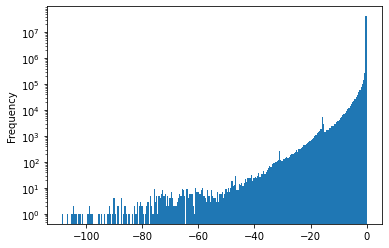

In [9]:
totalALRDF.ALR.plot.hist(bins=250, logy=True)

<AxesSubplot:ylabel='Frequency'>

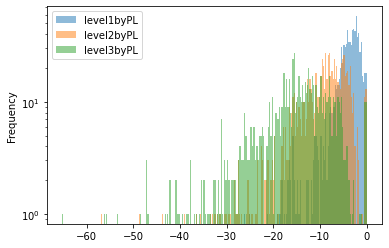

In [10]:
ThresholdsDF.drop(columns=['LocationId','WeeksGroup']).plot.hist(bins=250, alpha=0.5, logy=True)



In [23]:
print(ThresholdsDF.info(verbose=True))
print(ThresholdsDF.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 0 to 599
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  900 non-null    int64  
 1   LocationId  900 non-null    int64  
 2   WeeksGroup  900 non-null    int64  
 3   level1byPL  900 non-null    float64
 4   level2byPL  900 non-null    float64
 5   level3byPL  900 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 49.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 0 to 599
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  900 non-null    int64  
 1   LocationId  900 non-null    int64  
 2   WeeksGroup  900 non-null    int64  
 3   level1byPL  900 non-null    float64
 4   level2byPL  900 non-null    float64
 5   level3byPL  900 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 49.2 KB
None


In [25]:
print(pd.read_csv(CsvFilesThresholdsLoc).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  300 non-null    int64  
 1   LocationId  300 non-null    int64  
 2   WeeksGroup  300 non-null    int64  
 3   level1byPL  300 non-null    float64
 4   level2byPL  300 non-null    float64
 5   level3byPL  300 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 14.2 KB
None


In [8]:
#CsvFilesThresholdsLoc = 'exports/' + DatasetPrefix + '_thresholds_tmp_' + LocationPrefix + '.csv'
#totalALRDF.to_csv('exports/Cancan_Paris_alerts_grp12.csv')

totalALRDF.drop(columns=metrics).to_parquet(path='exports/Cancan_Paris_alerts_grp0_parquet', partition_cols=['week_of_year','LocationId'], index=False)

# apply the offlineML functions to aggregate thresholds for each antenna
#thresholds = totalALRDF.groupby(['LocationId', 'WeeksGroup']).ALR.agg([offlineMLbyPL.level1, offlineMLbyPL.level2, offlineMLbyPL.level3])

# don't forget to store the index or the following will be annoying
#thresholds.reset_index(inplace=True)
#thresholds.to_csv(CsvFilesThresholdsLoc, index=False)



In [ ]:


signatureDFs = []

ColumnsDropList = []
for m in metrics:
    ColumnsDropList.append(m+'_ref')

count = 0

distributionsDFList = []
    
with tqdm(total=len(LocIdsList)*len(WeekIdsList), desc='Signature extraction') as pbar:
    # run 2 imbricated loops, this hasn't much consequence on the output thanks to the filter / partitioning thing 
    for WeekGpId in WeekIdsList:
        for LocId in LocIdsList:
            #if LocId>10:
            #    break
            # gather all the data corresponding to the training group and the corresponding location
            # start with the location
            #OriginalDataLocSP = OriginalDataDFSP.filter(OriginalDataDFSP.LocationId == LocId)
            
            #start_time = time.time()
            referenceDF = wholeDF.loc[(wholeDF['WeeksGroup']==WeekGpId) & (wholeDF['LocationId']==LocId)].drop(columns=['LocationId'])
            #print("grabbing the ref time performed in " + str((time.time() - start_time)) + " seconds")
            
            # then the corresponding weeks. I believe that it's more convenient by unioning stuff
            #start_time = time.time()
            
            #OriginalDataDFList = []
            ErrorsDFsList = []
            for wk in TrainWeeksGroupsList[WeekGpId]:
                wkDF = OriginalDataDFSP.drop('time_utc').drop('time_local').filter((OriginalDataDFSP.week_of_year==wk) & (OriginalDataDFSP.LocationId == LocId)).toPandas().set_index('MinuteWithinWeek')
                wkDF = wkDF.reindex(range(0,24*7*60), fill_value=np.nan).assign(week_of_year=wk, LocationId=LocId)
                
                for m in metrics:
                    wkDF[m] = abs(wkDF[m] - referenceDF[m])
                
                #print("length wkDF :" + str(len(wkDF.index)))
                
                ErrorsDFsList.append( wkDF )
            
            errors = pd.concat(ErrorsDFsList)

            #if count>=10:
            #    print(errors.info())
            #    print(errors.describe())
            #    print(errors)
            
            #distributions = offlineMLbyPL.get_distrib_params(errors, meta=meta, metrics=metrics)
            distribution = pd.DataFrame(np.nan, index=['k','loc','theta'], columns=['LocationId', 'WeeksGroup', *metrics])
            distribution = distribution.assign(WeeksGroup=WeekGpId).assign(LocationId=LocId)
            distrib = offlineMLbyPL.fit_distribution(errors, metrics)
            for m in metrics:
                params = distrib[m]
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                distribution[m].iloc[0] = arg[0]
                distribution[m].iloc[1] = loc
                distribution[m].iloc[2] = scale
            
            count += 1
            
            #if count>10:
            #    print(distribution.info())
            #    print(distribution.describe())
            #    print(distribution)
            #    break

            pbar.update(1)
            
            distribution.index.names = ['GammaParam']
            distribution = distribution.reset_index()
            
            distributionsDFList.append(distribution)

            
distributionsDF = pd.concat(distributionsDFList)
#print(distributionsDF.info())
#print(distributionsDF.describe())
#print(distributionsDF)


distributionsDF.to_parquet(path=ParquetFilesDistribsLoc, partition_cols=['WeeksGroup','LocationId'], index=False)



Signature extraction:  56%|█████▋    | 1736/3078 [4:05:59<3:41:53,  9.92s/it]

In [8]:
print(distributionsDF.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9234 entries, k to theta
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LocationId   9234 non-null   int64  
 1   WeeksGroup   9234 non-null   int64  
 2   Voice        9150 non-null   float64
 3   SMS_3G       9126 non-null   float64
 4   PS           9147 non-null   float64
 5   CS           9150 non-null   float64
 6   Call         6238 non-null   float64
 7   SMS_4G       6246 non-null   float64
 8   Service_Req  6276 non-null   float64
 9   HO           6264 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 1.1+ MB
None


In [80]:
df = MediansDFSPAllMins.toPandas()
print(df.describe())
print(df.info(verbose=True))

          LocationId  MinuteWithinWeek          Voice         SMS_3G  \
count  272160.000000     272160.000000  272160.000000  272160.000000   
mean      504.222222       5039.500000       0.137254       0.035780   
std         2.897429       2909.850688       1.175929       0.347789   
min       500.000000          0.000000       0.000000       0.000000   
25%       502.000000       2519.750000       0.000000       0.000000   
50%       504.000000       5039.500000       0.000000       0.000000   
75%       506.000000       7559.250000       0.000000       0.000000   
max       509.000000      10079.000000      24.000000      24.000000   

                  PS             CS           Call         SMS_4G  \
count  272160.000000  272160.000000  272160.000000  272160.000000   
mean        4.869588       2.460204       0.120065       0.227623   
std        15.731381      11.132136       0.745263       1.151725   
min         0.000000       0.000000       0.000000       0.000000   
25%   

root
 |-- WeeksGroup: integer (nullable = true)
 |-- LocationId: integer (nullable = true)
 |-- MinuteWithinWeek: integer (nullable = true)
 |-- Voice: integer (nullable = true)
 |-- SMS_3G: integer (nullable = true)
 |-- PS: integer (nullable = true)
 |-- CS: integer (nullable = true)
 |-- Call: integer (nullable = true)
 |-- SMS_4G: integer (nullable = true)
 |-- Service_Req: integer (nullable = true)
 |-- HO: integer (nullable = true)

+----------+----------+----------------+-----+------+---+---+----+------+-----------+---+
|WeeksGroup|LocationId|MinuteWithinWeek|Voice|SMS_3G| PS| CS|Call|SMS_4G|Service_Req| HO|
+----------+----------+----------------+-----+------+---+---+----+------+-----------+---+
|         0|       780|             448|    0|     0|  5|  5|   0|     0|        115|  9|
|         0|       780|            1092|    0|     0| 11|  0|   1|     5|        226| 32|
|         0|       780|            1601|    0|     0|  1|  0|   0|     0|         72|  0|
|         0|     

In [11]:
MediansDF = MediansDF.sort_values(by=['MinuteWithinWeek'])
print(MediansDF)

from anr_discret import offlineMLbyPL




       MinuteWithinWeek  Voice  SMS_3G    PS    CS  Call  SMS_4G  Service_Req  \
0                  1029    4.0     0.0  24.0  19.0     4       6          637   
1                  1030    3.0     1.0  20.0  26.0     8       8          645   
2                  1031    3.0     1.0  19.0  21.0     6      13          629   
3                  1032    3.0     0.0  29.0  25.0     4       6          697   
4                  1033    4.0     0.0  25.0  26.0     4      16          709   
...                 ...    ...     ...   ...   ...   ...     ...          ...   
10075              9123    0.0     0.0   1.0   1.0     0       0          120   
10076              9124    0.0     0.0   1.0   3.0     0       0          141   
10077              9125    0.0     0.0   0.0   1.0     0       0          115   
10078              9126    0.0     0.0   3.0   4.0     0       0          126   
10079              9127    0.0     0.0   2.0   3.0     0       0           99   

        HO  WeeksGroup  Loc

In [15]:
# Agregate by location & date
metrics_3g = ['Voice','SMS_3G','PS','CS']
metrics_4g = ['Call','SMS_4G','Service_Req','HO']

cells_3g = cells_3g.groupBy(['LocInfo','Ts']).sum().drop('sum(Ts)')
cells_4g = cells_4g.groupBy(['LocInfo','Ts']).sum().drop('sum(Ts)')

for m in metrics_3g:
    cells_3g = cells_3g.withColumnRenamed('sum('+m+')', m)
for m in metrics_4g:
    cells_4g = cells_4g.withColumnRenamed('sum('+m+')', m)
    
# Add geographic coordinates
TOPO_FILEPATH = '/input_data/TestAngelo/DIOD/CELLS_TOPO/LocInfo_cancan_allcells_names_wgs.csv'
topo = spark.read.csv(TOPO_FILEPATH, inferSchema=True, sep=";", header=True)

c3 = cells_3g.alias('c3')
c4 = cells_4g.alias('c4')
topo = topo.alias('topo')
c3_topo = c3.join(topo, c3.LocInfo == topo.LocInfo)
c4_topo = c4.join(topo, c4.LocInfo == topo.LocInfo)

c3_topo = c3_topo.drop(topo.LocInfo) \
    .drop('TECHNO') \
    .drop('LAC') \
    .drop('min_dt') \
    .drop('max_dt') 
c4_topo = c4_topo.drop(topo.LocInfo) \
    .drop('TECHNO') \
    .drop('LAC') \
    .drop('min_dt') \
    .drop('max_dt') 

# Reformat date
c3_topo = c3_topo.na.fill(0) \
    .withColumn('Ts', f.col('Ts')+3600*2) \
    .withColumn('Ts', f.col('Ts').cast('string')) \
    .withColumn('Date', f.from_unixtime(f.col('Ts'), 'yyyy-MM-dd HH:mm')) \
    .orderBy('Date') \
    .drop('Ts')
c4_topo = c4_topo.na.fill(0) \
    .withColumn('Ts', f.col('Ts')*60+3600*2) \
    .withColumn('Ts', f.col('Ts').cast('string')) \
    .withColumn('Date', f.from_unixtime(f.col('Ts'), 'yyyy-MM-dd HH:mm')) \
    .orderBy('Date') \
    .drop('Ts')

# Agregate antennas by coordinates
clusters3 = c3_topo.groupBy(meta).sum()
clusters4 = c4_topo.groupBy(meta).sum()
for m in metrics_3g:
    clusters3 = clusters3.withColumnRenamed('sum('+m+')', m) \
        .drop('CI') \
        .drop('NOM_SITE')
for m in metrics_4g:
    clusters4 = clusters4.withColumnRenamed('sum('+m+')', m) \
        .drop('CI') \
        .drop('NOM_SITE')
    
# Reshape
clusters3 = clusters3.drop('sum(COORD_X)') \
    .drop('sum(COORD_Y)') \
    .drop('sum(LON)') \
    .drop('sum(LAT)') \
    .drop('sum(CI)') \
    .orderBy('Date')
clusters4 = clusters4.drop('sum(COORD_X)') \
    .drop('sum(COORD_Y)') \
    .drop('sum(LON)') \
    .drop('sum(LAT)') \
    .drop('sum(CI)') \
    .orderBy('Date')

# Merge 3G and 4G data
c3 = clusters3.alias('c3')
c4 = clusters4.alias('c4')
clusters = c3.join(c4, on=meta, how='outer').orderBy('Date')

clusters.printSchema()

root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 |-- COORD_Y: integer (nullable = true)
 |-- LON: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Voice: double (nullable = true)
 |-- PS: double (nullable = true)
 |-- SMS_3G: double (nullable = true)
 |-- CS: double (nullable = true)
 |-- Service_Req: double (nullable = true)
 |-- Call: double (nullable = true)
 |-- SMS_4G: double (nullable = true)
 |-- HO: double (nullable = true)



## 0.2 Separate training and testing datasets

In [7]:
clusters = clusters.withColumn('Date', f.to_timestamp(f.col('Date'), 'yyyy-MM-dd HH:mm'))

# found how to navigate between weeks here
# https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar

def iso_year_start(iso_year):
    #"The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    #"Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


# separating weeks within the dataset to make the training and testing tasks easier
for wId in range(24,26):
    TestIn = iso_to_gregorian(2019,wId,1)
    TestOut = iso_to_gregorian(2019,wId+1,1)
    
    print("storing dates between " + str(TestIn) + " and " + str(TestOut) + " as week " + str(wId))
    #print(TestOut)
    
    #continue

    #training = clusters.filter((clusters.Date < TestIn) | (clusters.Date >= TestOut)) 
    testing = clusters.filter((clusters.Date >= TestIn) & (clusters.Date < TestOut))
    
    print("found " + str(testing.count()) + " elements")
    testing.write.mode("overwrite").format('parquet').save('exports/' + LocationPrefix + '/dataset_' + LocationPrefix + '_week' + str(wId) + '.parquet')
    
    #testing.toPandas().to_csv('exports/Paris/testing_dataset_Paris_week' + str(wId) + '.csv', index=False)
    #training.toPandas().to_csv('exports/Paris/training_dataset_Paris_week' + str(wId) + '.csv', index=False)
    
    
#TestIn = datetime(2019,4,1,0,0)
#TestOut = datetime(2019,4,8,0,0)

#sep1 = datetime(2019,4,1,0,0)
#sep2 = datetime(2019,5,1,0,0)





NameError: name 'clusters' is not defined

In [5]:
# now trying to load previously written data
firstWeek = 10
lastWeek = 25

LocationPrefix = "Paris"


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys
#sys.path.append('../notebooks_evelyne/')

from anr_discret import offlineML
from anr_discret import onlineML




meta = ['COORD_X','LAT','COORD_Y','LON','Date']
coords = ['COORD_X','LAT','COORD_Y','LON']
metrics = ['Voice','SMS_3G','PS','CS','Call','SMS_4G','Service_Req','HO']






for testWeek in range(firstWeek+3, lastWeek+1):


    # loading the testData
    testData = spark.read.parquet('exports/' + LocationPrefix + '/dataset_' + LocationPrefix + '_week' + str(testWeek) + '.parquet')

    # now "unioning" all the training data together
    trainData = spark.read.parquet('exports/' + LocationPrefix + '/dataset_' + LocationPrefix + '_week' + str(firstWeek) + '.parquet')
    for indWeek in range(firstWeek, lastWeek):
        if indWeek == testWeek:
            continue
        trainData = trainData.union(spark.read.parquet('exports/' + LocationPrefix + '/dataset_' + LocationPrefix + '_week' + str(indWeek) + '.parquet'))

    trainData.printSchema()
    print("found " + str(trainData.count()) + " elements for the training part")
    print("found " + str(testData.count()) + " elements for the testing part")
    print("ratio testing/training : " + str(testData.count()/trainData.count()))
    
    
    train_df = trainData.toPandas()
    
    
    
    # offline training part
    
    # extract reference signatures
    
    locinfos = list(set(list(zip(train_df['COORD_X'], train_df['COORD_Y']))))
    signatures = {}
    with tqdm(total=len(locinfos), desc='Signature extraction') as pbar:
        for x,y in locinfos:
            if 0 not in (x,y):
                df = train_df.loc[(train_df['COORD_X'] == x) & (train_df['COORD_Y'] == y)]
                sig = offlineML.signature_weekly(df, date_col='Date')
                signatures[str(x)+str(y)] = offlineML.signature_filtered(sig, cutoff=8, metrics=metrics)
            pbar.update(1)
    
    SIGPATH = 'exports/' + LocationPrefix + '/w' + str(testWeek) + '/test_signatures_w' + str(testWeek) + '.csv'

    sig_df = pd.concat([df for df in signatures.values()])
    sig_df.to_csv(SIGPATH, index=False)

    
    
    # train error model
    train_df = train_df.fillna(0)
    train_df['new_index'] = train_df.Date.map(lambda t: str(t.dayofweek)+' '+str(t.hour)+' '+str(t.minute))
    
    
    real_time_signals = {}
    locinfos = list(set(list(zip(train_df['COORD_X'], train_df['COORD_Y']))))
    for x,y in locinfos:
        if 0 not in (x,y):
            real_time_signals[str(x)+str(y)] = train_df.loc[(train_df['COORD_X'] == x) & (train_df['COORD_Y'] == y)]
    
    
    errors = {}
    with tqdm(total=len(real_time_signals.keys()), desc='AE computing') as pbar:
        for k,df in real_time_signals.items():
            sig = signatures[k]
            join_df = df.join(sig[metrics], on='new_index', how='inner', rsuffix='_ref')
            errors[k] = offlineML.absolute_error(join_df, meta, metrics)
            pbar.update(1)
            
            
    distributions = {}
    with tqdm(total=len(errors.keys()), desc='Error distribution') as pbar:
        for k,df in errors.items():
            distributions[k] = offlineML.get_distrib_params(df, meta=coords, metrics=metrics)
            pbar.update(1)
            
            
    distrib_df = pd.concat([df for df in distributions.values()])
    distrib_df.to_csv('exports/' + LocationPrefix + '/w' + str(testWeek) + '/test_distributions_w' + str(testWeek) + '.csv', index=False)
    
    # compute anomaly likelihood rates
    with tqdm(total=len(errors.keys()), desc='ALR computing') as pbar:
        for k,df in errors.items():
            errors[k] = offlineML.compute_alr(df, distributions[k], metrics)
            pbar.update(1)
    
    # Set ALR thresholds
    errors_df = pd.concat([df for df in errors.values()])

    # apply the offlineML functions to aggregate thresholds for each antenna
    thresholds = errors_df.groupby(coords).ALR.agg([offlineML.level1, offlineML.level2, offlineML.level3])

    # don't forget to store the index or the following will be annoying
    thresholds.reset_index(inplace=True)
    thresholds.to_csv('exports/' + LocationPrefix + '/w' + str(testWeek) + '/test_multilevel_thresholds_sample_test_w' + str(testWeek) + '.csv', index=False)
    
    
    
    
    ## Real-time detection
    # Load real-time data and merge with signatures
    test_df = testData.toPandas()
    test_df.set_index('Date', inplace=True)
    test_df.index = pd.to_datetime(test_df.index, format='%Y-%m-%d %H:%M:%S')  
    test_df = test_df.fillna(0)
    test_df['new_index'] = test_df.index.map(lambda t: str(t.dayofweek)+' '+str(t.hour)+' '+str(t.minute))

    locinfos = list(set(list(zip(test_df['COORD_X'], test_df['COORD_Y']))))
    real_time_signals = {}

    for x,y in locinfos:
        if 0 not in (x,y):
            df = test_df.loc[(test_df['COORD_X'] == x) & (test_df['COORD_Y'] == y)]
            real_time_signals[str(x)+str(y)] = df

    clean = {}
    for k,df in real_time_signals.items():
        if len(df)>0:
            clean[k] = df
    real_time_signals = clean
    
    
    
    drops = []

    for x,y in locinfos:
        if 0 not in (x,y):
            sig = sig_df.loc[(sig_df['COORD_X'] == x) & (sig_df['COORD_Y'] == y)]
            if len(sig)>0:
                df = real_time_signals[str(x)+str(y)]
                real_time_signals[str(x)+str(y)] = df.join(sig[metrics], on='new_index', how='inner', rsuffix='_ref').sort_index()
            else:
                drops.append(str(x)+str(y))

    for d in drops:
        del real_time_signals[d]
        
        
    # Apply the trained model to the data
    # compute absolute errors
    errors = {}
    with tqdm(total=len(real_time_signals.keys()), desc='AE computation') as pbar:
        for k,df in real_time_signals.items():
            errors[k] = onlineML.absolute_error(df, meta=coords, metrics=metrics)
            pbar.update(1)
            
            
    # Load model parameters and compute Anomaly Likelihood Rate
    locinfos = list(set(list(zip(distrib_df['COORD_X'], distrib_df['COORD_Y']))))
    distributions = {}
    for x,y in locinfos:
        if 0 not in (x,y):
            df = distrib_df.loc[(distrib_df['COORD_X'] == x) & (distrib_df['COORD_Y'] == y)]
            df['param'] = ['k','loc','theta']
            df.set_index(df.param, inplace=True)
            distributions[str(int(x))+str(int(y))] = df.drop('param', axis=1)

    #thresholds = pd.read_csv('exports/Paris/multilevel_thresholds_sample_w' + str(testWeek) + '.csv')
    thresholds['ID'] = thresholds.COORD_X.astype(str)+thresholds.COORD_Y.astype(str)
    thresholds.set_index('ID', inplace=True)
    thresholds = thresholds.drop(['COORD_X','COORD_Y'], axis=1)
    
    
    with tqdm(total=len(errors.keys()), desc='ALR computation') as pbar:
        for k,df in errors.items():
            onlineML.compute_alr(df, distributions[k], metrics)    
            pbar.update(1)
    
    
    # Set anomaly levels on the real-time data
    with tqdm(total=len(errors.keys()), desc='Setting anomaly levels') as pbar:
        for k,df in errors.items():
            thresh = onlineML.get_threshold(k, thresholds)
            df = onlineML.replace_inf(df, metrics, thresh)   
            errors[k] = onlineML.set_levels(df, thresh)
            pbar.update(1)
            
    full_df = pd.concat([df[[*coords,'ALR','Anomaly_Level']] for df in errors.values()])
    print(full_df.describe())
    #full_df.to_csv('exports/' + LocationPrefix + '/w' + str(testWeek) + '/test_alr_levels_w' + str(testWeek) + '.csv', index=False)
    full_df.to_csv('exports/' + LocationPrefix + '/w' + str(testWeek) + '/index_alr_levels_w' + str(testWeek) + '_with_index.csv')
    
    #break
            

root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 |-- COORD_Y: integer (nullable = true)
 |-- LON: double (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Voice: double (nullable = true)
 |-- PS: double (nullable = true)
 |-- SMS_3G: double (nullable = true)
 |-- CS: double (nullable = true)
 |-- Service_Req: double (nullable = true)
 |-- Call: double (nullable = true)
 |-- SMS_4G: double (nullable = true)
 |-- HO: double (nullable = true)

found 17591636 elements for the training part
found 1508832 elements for the testing part
ratio testing/training : 0.08576985108150259


Setting anomaly levels: 100%|██████████| 174/174 [00:01<00:00, 130.28it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.505657e+06  1.505657e+06  1.505657e+06  1.505657e+06  1.505657e+06   
mean   6.009633e+05  4.885617e+01  2.428648e+06  2.349625e+00 -1.580131e+01   
std    7.002287e+02  9.433704e-03  1.049652e+03  9.536984e-03  1.679684e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -2.566606e+02   
25%    6.004040e+05  4.884927e+01  2.427880e+06  2.342009e+00 -2.113810e+01   
50%    6.009080e+05  4.885714e+01  2.428756e+06  2.348874e+00 -1.112667e+01   
75%    6.014710e+05  4.886338e+01  2.429451e+06  2.356543e+00 -4.498597e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -1.490707e-02   

       Anomaly_Level  
count   1.505657e+06  
mean    1.137284e-01  
std     3.870386e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 176/176 [00:01<00:00, 130.70it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.487133e+06  1.487133e+06  1.487133e+06  1.487133e+06  1.487133e+06   
mean   6.009675e+05  4.885622e+01  2.428653e+06  2.349683e+00 -1.557253e+01   
std    6.999319e+02  9.396839e-03  1.045551e+03  9.532959e-03  1.717277e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -2.906399e+02   
25%    6.004190e+05  4.884927e+01  2.427880e+06  2.342213e+00 -2.050502e+01   
50%    6.009200e+05  4.885721e+01  2.428764e+06  2.349038e+00 -1.024093e+01   
75%    6.014820e+05  4.886338e+01  2.429451e+06  2.356695e+00 -4.071460e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -1.466140e-02   

       Anomaly_Level  
count   1.487133e+06  
mean    1.284942e-01  
std     4.071225e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 177/177 [00:01<00:00, 129.06it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.532747e+06  1.532747e+06  1.532747e+06  1.532747e+06  1.532747e+06   
mean   6.009736e+05  4.885629e+01  2.428662e+06  2.349766e+00 -1.471656e+01   
std    7.005660e+02  9.418594e-03  1.047972e+03  9.541613e-03  1.618057e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -2.583276e+02   
25%    6.004190e+05  4.884927e+01  2.427880e+06  2.342213e+00 -1.980937e+01   
50%    6.009410e+05  4.885724e+01  2.428767e+06  2.349319e+00 -1.008709e+01   
75%    6.014820e+05  4.886372e+01  2.429488e+06  2.356695e+00 -3.938191e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -1.495355e-02   

       Anomaly_Level  
count   1.532747e+06  
mean    1.045352e-01  
std     3.751881e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 177/177 [00:01<00:00, 133.41it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.529137e+06  1.529137e+06  1.529137e+06  1.529137e+06  1.529137e+06   
mean   6.009753e+05  4.885633e+01  2.428666e+06  2.349790e+00 -1.515151e+01   
std    7.009699e+02  9.437361e-03  1.050060e+03  9.547133e-03  1.687367e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -3.017017e+02   
25%    6.004190e+05  4.884933e+01  2.427887e+06  2.342213e+00 -2.028553e+01   
50%    6.009410e+05  4.885725e+01  2.428768e+06  2.349319e+00 -1.020623e+01   
75%    6.015130e+05  4.886372e+01  2.429488e+06  2.357104e+00 -4.010241e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -1.706767e-02   

       Anomaly_Level  
count   1.529137e+06  
mean    1.148295e-01  
std     3.938407e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 178/178 [00:01<00:00, 135.03it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.429963e+06  1.429963e+06  1.429963e+06  1.429963e+06  1.429963e+06   
mean   6.009784e+05  4.885629e+01  2.428662e+06  2.349832e+00 -1.357609e+01   
std    6.992677e+02  9.493410e-03  1.056296e+03  9.523928e-03  1.318850e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -2.133561e+02   
25%    6.004450e+05  4.884927e+01  2.427880e+06  2.342568e+00 -1.856353e+01   
50%    6.009410e+05  4.885725e+01  2.428768e+06  2.349319e+00 -1.003238e+01   
75%    6.015130e+05  4.886372e+01  2.429488e+06  2.357104e+00 -4.204532e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -1.652829e-02   

       Anomaly_Level  
count   1.429963e+06  
mean    6.082885e-02  
std     2.593139e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 178/178 [00:01<00:00, 135.28it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.494096e+06  1.494096e+06  1.494096e+06  1.494096e+06  1.494096e+06   
mean   6.009758e+05  4.885632e+01  2.428665e+06  2.349796e+00 -1.350988e+01   
std    6.994664e+02  9.451798e-03  1.051666e+03  9.526644e-03  1.400256e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -2.826566e+02   
25%    6.004450e+05  4.884927e+01  2.427880e+06  2.342568e+00 -1.799608e+01   
50%    6.009200e+05  4.885725e+01  2.428768e+06  2.349038e+00 -9.588841e+00   
75%    6.015130e+05  4.886396e+01  2.429515e+06  2.357104e+00 -4.021389e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -1.968911e-02   

       Anomaly_Level  
count   1.494096e+06  
mean    6.861808e-02  
std     2.801435e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 178/178 [00:01<00:00, 138.99it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.319008e+06  1.319008e+06  1.319008e+06  1.319008e+06  1.319008e+06   
mean   6.009711e+05  4.885636e+01  2.428669e+06  2.349733e+00 -1.409193e+01   
std    6.995270e+02  9.428595e-03  1.049085e+03  9.527482e-03  1.460486e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -2.416931e+02   
25%    6.004190e+05  4.885029e+01  2.427994e+06  2.342213e+00 -1.886256e+01   
50%    6.009200e+05  4.885725e+01  2.428768e+06  2.349038e+00 -9.921472e+00   
75%    6.014820e+05  4.886396e+01  2.429515e+06  2.356695e+00 -4.084582e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -9.880588e-03   

       Anomaly_Level  
count   1.319008e+06  
mean    8.531942e-02  
std     3.198473e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 178/178 [00:01<00:00, 133.33it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.553428e+06  1.553428e+06  1.553428e+06  1.553428e+06  1.553428e+06   
mean   6.009707e+05  4.885638e+01  2.428671e+06  2.349727e+00 -1.420566e+01   
std    7.005708e+02  9.408659e-03  1.046866e+03  9.541695e-03  1.539550e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -3.462038e+02   
25%    6.004190e+05  4.885029e+01  2.427994e+06  2.342213e+00 -1.900966e+01   
50%    6.009200e+05  4.885725e+01  2.428768e+06  2.349038e+00 -9.829711e+00   
75%    6.015130e+05  4.886396e+01  2.429515e+06  2.357104e+00 -3.968806e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -1.893574e-02   

       Anomaly_Level  
count   1.553428e+06  
mean    9.047346e-02  
std     3.401442e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 178/178 [00:01<00:00, 146.82it/s]


             COORD_X            LAT       COORD_Y            LON  \
count  781032.000000  781032.000000  7.810320e+05  781032.000000   
mean   600972.978281      48.856230  2.428655e+06       2.349758   
std       699.499912       0.009523  1.059538e+03       0.009527   
min    599580.000000      48.834285  2.426213e+06       2.330786   
25%    600445.000000      48.848800  2.427828e+06       2.342568   
50%    600920.000000      48.857248  2.428768e+06       2.349038   
75%    601482.000000      48.863719  2.429488e+06       2.356695   
max    602467.000000      48.872329  2.430446e+06       2.370104   

                 ALR  Anomaly_Level  
count  781032.000000  781032.000000  
mean      -13.745576       0.099602  
std        14.831575       0.343146  
min      -268.608687       0.000000  
25%       -17.989177       0.000000  
50%        -9.196963       0.000000  
75%        -3.775725       0.000000  
max        -0.023187       3.000000  
root
 |-- COORD_X: integer (nullable = true)


Setting anomaly levels: 100%|██████████| 178/178 [00:01<00:00, 127.86it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.530711e+06  1.530711e+06  1.530711e+06  1.530711e+06  1.530711e+06   
mean   6.009736e+05  4.885636e+01  2.428669e+06  2.349766e+00 -1.411424e+01   
std    6.992587e+02  9.419778e-03  1.048103e+03  9.523821e-03  1.495839e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -2.207382e+02   
25%    6.004190e+05  4.885029e+01  2.427994e+06  2.342213e+00 -1.907243e+01   
50%    6.009200e+05  4.885725e+01  2.428768e+06  2.349038e+00 -9.799137e+00   
75%    6.014820e+05  4.886396e+01  2.429515e+06  2.356695e+00 -4.011522e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -6.868533e-03   

       Anomaly_Level  
count   1.530711e+06  
mean    9.309791e-02  
std     3.399778e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 178/178 [00:01<00:00, 130.85it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.544571e+06  1.544571e+06  1.544571e+06  1.544571e+06  1.544571e+06   
mean   6.009688e+05  4.885636e+01  2.428669e+06  2.349701e+00 -1.411094e+01   
std    7.012869e+02  9.435005e-03  1.049798e+03  9.551451e-03  1.464000e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -2.185480e+02   
25%    6.004190e+05  4.884933e+01  2.427887e+06  2.342213e+00 -1.922052e+01   
50%    6.009200e+05  4.885725e+01  2.428768e+06  2.349038e+00 -9.920849e+00   
75%    6.015130e+05  4.886396e+01  2.429515e+06  2.357104e+00 -4.015574e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -8.201063e-03   

       Anomaly_Level  
count   1.544571e+06  
mean    9.361952e-02  
std     3.738755e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

Setting anomaly levels: 100%|██████████| 177/177 [00:01<00:00, 135.92it/s]


            COORD_X           LAT       COORD_Y           LON           ALR  \
count  1.442931e+06  1.442931e+06  1.442931e+06  1.442931e+06  1.442931e+06   
mean   6.009646e+05  4.885635e+01  2.428669e+06  2.349643e+00 -1.419713e+01   
std    6.992094e+02  9.464687e-03  1.053101e+03  9.523160e-03  1.518542e+01   
min    5.995800e+05  4.883429e+01  2.426213e+06  2.330786e+00 -3.008162e+02   
25%    6.004190e+05  4.884927e+01  2.427880e+06  2.342213e+00 -1.924708e+01   
50%    6.009200e+05  4.885725e+01  2.428768e+06  2.349038e+00 -9.820761e+00   
75%    6.014820e+05  4.886396e+01  2.429515e+06  2.356695e+00 -3.961217e+00   
max    6.024670e+05  4.887233e+01  2.430446e+06  2.370104e+00 -2.184786e-02   

       Anomaly_Level  
count   1.442931e+06  
mean    9.416874e-02  
std     3.477299e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     3.000000e+00  
root
 |-- COORD_X: integer (nullable = true)
 |-- LAT: double (nullable = true)
 

AE computing:  38%|███▊      | 68/178 [00:14<00:24,  4.43it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [5]:
train_df = trainData.toPandas()

# M.1 Offline training

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys
#sys.path.append('../notebooks_evelyne/')

from anr_discret import offlineML

In [7]:
meta = ['COORD_X','LAT','COORD_Y','LON','Date']
coords = ['COORD_X','LAT','COORD_Y','LON']
metrics = ['Voice','SMS_3G','PS','CS','Call','SMS_4G','Service_Req','HO']

## 1.1 Extract reference signatures

In [8]:
locinfos = list(set(list(zip(train_df['COORD_X'], train_df['COORD_Y']))))
signatures = {}
with tqdm(total=len(locinfos), desc='Signature extraction') as pbar:
    for x,y in locinfos:
        if 0 not in (x,y):
            df = train_df.loc[(train_df['COORD_X'] == x) & (train_df['COORD_Y'] == y)]
            sig = offlineML.signature_weekly(df, date_col='Date')
            signatures[str(x)+str(y)] = offlineML.signature_filtered(sig, cutoff=8, metrics=metrics)
        pbar.update(1)

Signature extraction: 100%|██████████| 178/178 [00:34<00:00,  5.13it/s]


In [9]:
SIGPATH = 'exports/' + LocationPrefix + '/w' + str(testWeek) + '/signatures_w' + str(testWeek) + '.csv'

sig_df = pd.concat([df for df in signatures.values()])
sig_df.to_csv(SIGPATH, index=False)

## 1.2 Train error model
### 1.2.1 Compute absolute errors

In [10]:
train_df = train_df.fillna(0)
train_df['new_index'] = train_df.Date.map(lambda t: str(t.dayofweek)+' '+str(t.hour)+' '+str(t.minute))

In [82]:
real_time_signals = {}
locinfos = list(set(list(zip(train_df['COORD_X'], train_df['COORD_Y']))))
for x,y in locinfos:
    if 0 not in (x,y):
        real_time_signals[str(x)+str(y)] = train_df.loc[(train_df['COORD_X'] == x) & (train_df['COORD_Y'] == y)]

In [83]:
errors = {}
with tqdm(total=len(real_time_signals.keys()), desc='AE computing') as pbar:
    for k,df in real_time_signals.items():
        sig = signatures[k]
        join_df = df.join(sig[metrics], on='new_index', how='inner', rsuffix='_ref')
        errors[k] = offlineML.absolute_error(join_df, meta, metrics)
        pbar.update(1)

AE computing: 100%|██████████| 178/178 [00:31<00:00,  5.57it/s]


In [63]:
distributions = {}
with tqdm(total=len(errors.keys()), desc='Error distribution') as pbar:
    for k,df in errors.items():
        distributions[k] = offlineML.get_distrib_params(df, meta=coords, metrics=metrics)
        pbar.update(1)

Error distribution: 100%|██████████| 178/178 [24:08<00:00,  8.14s/it]


In [84]:
distrib_df = pd.concat([df for df in distributions.values()])
distrib_df.to_csv('exports/' + LocationPrefix + '/w' + str(testWeek) + '/distributions_w' + str(testWeek) + '.csv', index=False)

### 1.2.2 Compute Anomaly Likelihood Rate

In [85]:
with tqdm(total=len(errors.keys()), desc='ALR computing') as pbar:
    for k,df in errors.items():
        errors[k] = offlineML.compute_alr(df, distributions[k], metrics)
        pbar.update(1)

ALR computing: 100%|██████████| 178/178 [00:54<00:00,  3.29it/s]


### 1.2.3 Set ALR thresholds

In [97]:
errors_df = pd.concat([df for df in errors.values()])

# apply the offlineML functions to aggregate thresholds for each antenna
thresholds = errors_df.groupby(coords).ALR.agg([offlineML.level1, offlineML.level2, offlineML.level3])

# don't forget to store the index or the following will be annoying
thresholds.reset_index(inplace=True)
thresholds.to_csv('exports/' + LocationPrefix + '/w' + str(testWeek) + '/multilevel_thresholds_sample_test_w' + str(testWeek) + '.csv', index=False)

# M.2 Real-time detection

In [69]:
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from anr_discret import onlineML

In [70]:
meta = ['COORD_X','LAT','COORD_Y','LON','Date']
coords = ['COORD_X','LAT','COORD_Y','LON']
metrics = ['Voice','SMS_3G','PS','CS','Call','SMS_4G','Service_Req','HO']

## 2.1 Load real-time data and merge with signatures

In [73]:
#TESTINGPATH = 'exports/Paris/testing_dataset_NotreDame.csv'

#testing = pd.read_csv(TESTINGPATH, sep=',').drop('Unnamed: 0', axis=1)
#testing.set_index('Date', inplace=True)
#testing.index = pd.to_datetime(testing.index, format='%Y-%m-%d %H:%M:%S')  
#testing = testing.fillna(0)
#testing['new_index'] = testing.index.map(lambda t: str(t.dayofweek)+' '+str(t.hour)+' '+str(t.minute))

# loading the testData through spark, when needed
#testData = spark.read.parquet('exports/Paris/dataset_Paris_week' + str(testWeek) + '.parquet')

test_df = testData.toPandas()
test_df.set_index('Date', inplace=True)
test_df.index = pd.to_datetime(test_df.index, format='%Y-%m-%d %H:%M:%S')  
test_df = test_df.fillna(0)
test_df['new_index'] = test_df.index.map(lambda t: str(t.dayofweek)+' '+str(t.hour)+' '+str(t.minute))

locinfos = list(set(list(zip(test_df['COORD_X'], test_df['COORD_Y']))))
real_time_signals = {}

for x,y in locinfos:
    if 0 not in (x,y):
        df = test_df.loc[(test_df['COORD_X'] == x) & (test_df['COORD_Y'] == y)]
        real_time_signals[str(x)+str(y)] = df
        
clean = {}
for k,df in real_time_signals.items():
    if len(df)>0:
        clean[k] = df
real_time_signals = clean

In [75]:
#SIGPATH = 'exports/Paris/signatures_NotreDame_w' + str(testWeek) + '.csv'

#sig_df = pd.read_csv(SIGPATH).fillna(0)

drops = []

for x,y in locinfos:
    if 0 not in (x,y):
        sig = sig_df.loc[(sig_df['COORD_X'] == x) & (sig_df['COORD_Y'] == y)]
        if len(sig)>0:
            df = real_time_signals[str(x)+str(y)]
            real_time_signals[str(x)+str(y)] = df.join(sig[metrics], on='new_index', how='inner', rsuffix='_ref').sort_index()
        else:
            drops.append(str(x)+str(y))

for d in drops:
    del real_time_signals[d]

## 2.2 Apply the trained model to the data
### 2.2.1 Compute absolute errors

In [76]:
errors = {}
with tqdm(total=len(real_time_signals.keys()), desc='AE computation') as pbar:
    for k,df in real_time_signals.items():
        errors[k] = onlineML.absolute_error(df, meta=coords, metrics=metrics)
        pbar.update(1)

AE computation: 100%|██████████| 176/176 [00:02<00:00, 66.24it/s]


### 2.2.2 Load model parameters and compute Anomaly Likelihood Rate

In [100]:
#distrib_params = pd.read_csv('exports/Paris/distributions_NotreDame_w' + str(testWeek) + '.csv').drop('Unnamed: 0', axis=1)

locinfos = list(set(list(zip(distrib_df['COORD_X'], distrib_df['COORD_Y']))))
distributions = {}
for x,y in locinfos:
    if 0 not in (x,y):
        df = distrib_df.loc[(distrib_df['COORD_X'] == x) & (distrib_df['COORD_Y'] == y)]
        df['param'] = ['k','loc','theta']
        df.set_index(df.param, inplace=True)
        distributions[str(int(x))+str(int(y))] = df.drop('param', axis=1)
        
#thresholds = pd.read_csv('exports/Paris/multilevel_thresholds_sample_w' + str(testWeek) + '.csv')
thresholds['ID'] = thresholds.COORD_X.astype(str)+thresholds.COORD_Y.astype(str)
thresholds.set_index('ID', inplace=True)
thresholds = thresholds.drop(['COORD_X','COORD_Y'], axis=1)

             COORD_X         LAT       COORD_Y         LON      level1  \
count     178.000000  178.000000  1.780000e+02  178.000000  178.000000   
mean   600968.657303   48.856379  2.428671e+06    2.349699  -32.895307   
std       713.653416    0.009313  1.036189e+03    0.009720   11.597300   
min    599580.000000   48.834285  2.426213e+06    2.330786  -67.279578   
25%    600407.750000   48.850317  2.427997e+06    2.342060  -40.236093   
50%    600930.500000   48.857242  2.428768e+06    2.349178  -32.000982   
75%    601527.250000   48.863635  2.429479e+06    2.357305  -24.125937   
max    602467.000000   48.872329  2.430446e+06    2.370104  -12.342845   

           level2      level3  
count  178.000000  178.000000  
mean   -58.865775  -97.737382  
std     19.868445   30.959401  
min   -130.594862 -181.218277  
25%    -69.608578 -122.041490  
50%    -55.385635  -92.636212  
75%    -43.706491  -71.322860  
max    -21.751426  -33.928148  


In [101]:
with tqdm(total=len(errors.keys()), desc='ALR computation') as pbar:
    for k,df in errors.items():
        onlineML.compute_alr(df, distributions[k], metrics)    
        pbar.update(1)

ALR computation: 100%|██████████| 178/178 [00:45<00:00,  3.90it/s]


### 2.2.3 Set anomaly levels on the real-time data

In [102]:
with tqdm(total=len(errors.keys()), desc='Setting anomaly levels') as pbar:
    for k,df in errors.items():
        thresh = onlineML.get_threshold(k, thresholds)
        df = onlineML.replace_inf(df, metrics, thresh)   
        errors[k] = onlineML.set_levels(df, thresh)
        pbar.update(1)

Setting anomaly levels: 100%|██████████| 178/178 [00:06<00:00, 25.87it/s]


In [104]:
full_df = pd.concat([df[[*coords,'ALR','Anomaly_Level']] for df in errors.values()])
#print(full_df.describe())
full_df.to_csv('exports/' + LocationPrefix + '/w' + str(testWeek) + '/alr_levels_w' + str(testWeek) + '.csv', index=False)

## Visualization by antenna

In [105]:
from anr_discret import carto

In [15]:
#k = '6007152428426' 
#df,err = real_time_signals[k], errors[k]
#thresh = thresholds.loc[thresholds.index==k].iloc[0]
#dates = [datetime(2019,4,15,18,50), datetime(2019,4,15,18,57), datetime(2019,4,15,19,4)]

In [ ]:
carto.create_heatmap(full_df)